<a href="https://colab.research.google.com/github/A23929/MDSC-302-Assignments/blob/main/22237_MDSC_302(P)_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:03<00:00, 49319454.11it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
training_data.data.shape

(50000, 32, 32, 3)

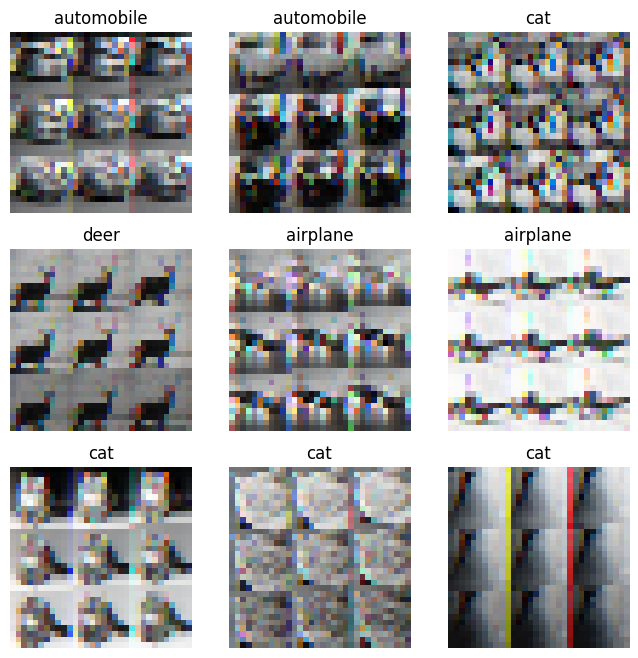

In [ ]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.reshape(32,32,3), cmap="gray")
plt.show()

In [ ]:
train_size = int(0.9*(len(training_data)))
val_size = len(training_data) - train_size
train_set, val_set = random_split(training_data, [train_size, val_size])

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_set,batch_size = 64,shuffle=True)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


<ipython-input-7-79936de07f74>:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(img.T,cmap='gray')


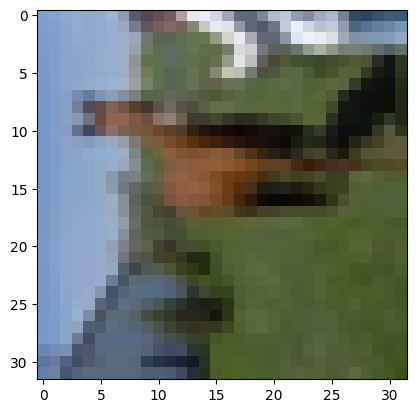

Label: 7


In [ ]:
train_features,train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
plt.imshow(img.T,cmap='gray')
plt.show()
print(f"Label: {label}")

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = nn.Sequential(
      nn.Conv2d(3,32,3, 1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(32, 64, 3, 1),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2),
      nn.Dropout(0.25),
    )
    self.block2 = nn.Sequential(
      nn.Flatten(),
      nn.Linear(12544, 128),
      nn.BatchNorm1d(128),
      nn.ReLU(inplace=True),
      nn.Dropout(0.5),
      nn.Linear(128,10),
      nn.BatchNorm1d(10)
    )
  def forward(self, x):
    x = self.block1(x.float())
    return self.block2(x)

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
model = Net().to(device)
print(model)

Net(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=10, bias=True)
    (6): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [ ]:
learning_rate = 1e-4
batch_size = 64
epochs = 5

In [ ]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
tloss = []
tacc = []
vloss = []
vacc = []

In [ ]:
for epochs in range(20):
  running_loss = 0.0
  num_correct = 0

  print(f"Epoch {epochs+1}\n------------------------------------------")

  for inputs, labels in train_dataloader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    running_loss += loss.item()
    optimizer.step()
    _, idx = outputs.max(dim=1)
    num_correct += (idx == labels).sum().item()

  print('Loss: {} Accuracy: {}'.format(running_loss/len(train_dataloader),
  (num_correct/len(train_dataloader))/100))

  tloss.append(running_loss/len(train_dataloader))
  tacc.append((num_correct/len(train_dataloader))/100)

  size = len(val_dataloader.dataset)
  num_batches = len(val_dataloader)
  val_loss, correct = 0, 0

  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape)
        pred = model(inputs)
        val_loss += loss_fn(pred, labels).item()
        correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Validation error : \n Accuracy: {(correct)}, Avg loss: {val_loss:>8f} \n")

  vloss.append(val_loss)
  vacc.append(correct)

Epoch 1
------------------------------------------
Loss: 0.0006607843176386781 Accuracy: 0.6390767045454545
Validation error : 
 Accuracy: 0.6956, Avg loss: 3.739976 

Epoch 2
------------------------------------------
Loss: 1.8463315535221818e-05 Accuracy: 0.6392045454545454
Validation error : 
 Accuracy: 0.6944, Avg loss: 3.709652 

Epoch 3
------------------------------------------
Loss: 7.689096522514847e-06 Accuracy: 0.6392045454545454
Validation error : 
 Accuracy: 0.6952, Avg loss: 3.720490 

Epoch 4
------------------------------------------
Loss: 5.480582055128469e-06 Accuracy: 0.6392045454545454
Validation error : 
 Accuracy: 0.697, Avg loss: 3.732971 

Epoch 5
------------------------------------------
Loss: 4.05679707466045e-06 Accuracy: 0.6392045454545454
Validation error : 
 Accuracy: 0.6968, Avg loss: 3.772027 

Epoch 6
------------------------------------------
Loss: 3.0608959485317104e-06 Accuracy: 0.6392045454545454
Validation error : 
 Accuracy: 0.696, Avg loss: 3.79

In [ ]:
print(tloss)

[0.030580021138606837, 0.02095085447179589, 0.027009028804209058, 0.025383018333958385, 0.020025901389170094, 0.020266621370113116, 0.02753944447001996, 0.016779491708278596, 0.020419192043949475, 0.021386300036974667, 0.015364497916519585, 0.01806755604259923, 0.023156800973309674, 0.025351919134751908, 0.014867503653728808, 0.015050871399943523, 0.026283727672532366, 0.013521795362237299, 0.013827533748225733, 0.011892331236221697]


In [ ]:
print(vloss)

[2.9119852419140972, 2.9670469021495385, 3.1385185492189627, 3.057202293903013, 3.016941295394415, 3.4991667119762564, 2.9178375896019273, 3.1016887954518766, 3.079595872118503, 3.051761352563206, 3.360890009735204, 3.467324760895741, 3.3145286101329177, 3.420027701160576, 3.1674481403978567, 3.3808690445332585, 3.1844353917278823, 3.247163525487803, 3.498950316936155, 3.2138141680367385]


In [ ]:
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss, test_correct = 0, 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
  for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs)
    test_loss += loss_fn(pred, labels).item()
    test_correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

  test_loss /= num_batches
  test_correct /= size
  print(f"Test error : \n Accuracy: {(test_correct)}, Avg loss: {test_loss:>8f} \n")

Test error : 
 Accuracy: 0.7045, Avg loss: 4.224038 



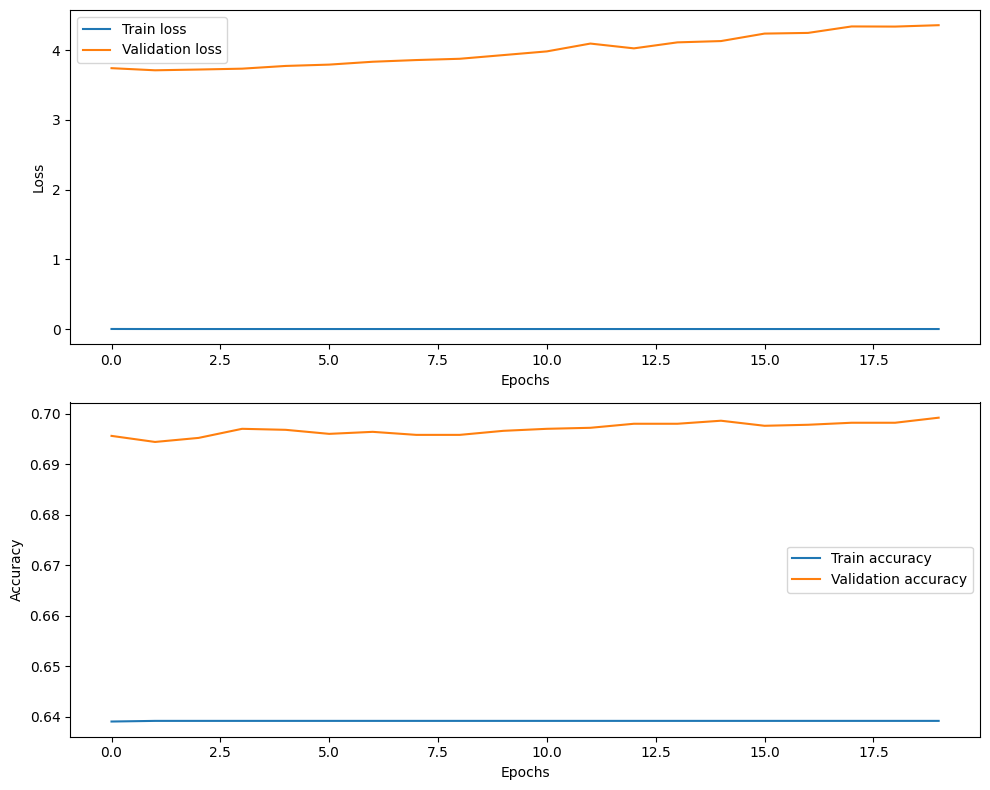

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
ax1.plot(range(0,epochs+1),tloss,label='Train loss')
ax1.plot(range(0,epochs+1),vloss,label='Validation loss')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(range(0,epochs+1),tacc,label='Train accuracy')
ax2.plot(range(0,epochs+1),vacc,label='Validation accuracy')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()